In [10]:
import re
import json
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from omegaconf import OmegaConf
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, multilabel_confusion_matrix, matthews_corrcoef
from scipy.stats import spearmanr
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

from cgeval.rating import Ratings, Label, Observation

In [2]:
BASE_PATH = f'../../out/pipeline'

IMAGE_MODEL = {
    'Stable Diffusion 3.5': f'{BASE_PATH}/2025-05-15_animal_detection_stable-diffusion_count',
    'Stable Cascade': f'{BASE_PATH}/2025-05-15_animal_detection_stable-cascade_count',
    'FLUX.1-dev': f'{BASE_PATH}/2025-05-15_animal_detection_flux_count'
}

IMAGE_MODEL_ANIMAL = {
    'Stable Diffusion 3.5': f'{BASE_PATH}/2025-05-15_animal_detection_stable-diffusion_animal',
    'Stable Cascade': f'{BASE_PATH}/2025-05-15_animal_detection_stable-cascade_animal',
    'FLUX.1-dev': f'{BASE_PATH}/2025-05-15_animal_detection_flux_animal'
}

cls_name2id = {
    'LLaVA': 'LVV',
    'Yolov8': 'YLO',
    'DETR': 'DTR',
}

In [3]:
def label_name_to_id(name: str, labels) -> int:
    return next((l['id'] for l in labels if l['name'] == name), None)

def label_match_to_id(match: str, matching_label: str) -> int:
    return int(match == matching_label) if match is not None else match

def load_ratings(cfg, classifier, report_path):
    with open(f"{report_path}/evaluate/dataset_{classifier.id}.json", 'r') as f:
        ratings_data = json.load(f)

    observations = list(map(lambda i: Observation(
        id=i['id'],
        output=i['output'],
        input=1,
        oracle=label_match_to_id(i['oracle'], classifier.labels[1].name),
        metric=label_match_to_id(i['metric'], classifier.labels[1].name)
    ), ratings_data))

    labels = list(map(lambda l: Label(**l), classifier.labels))

    return Ratings(labels=labels, observations=observations)


In [4]:
def pretty_print_latex(latex_str):
    lines = latex_str.replace(r" \\ ", r" \\" + "\n").splitlines()
    formatted_lines = []
    indent_level = 0
    for line in lines:
        if r"\begin" in line:
            formatted_lines.append(line)
            indent_level += 1
        elif r"\end" in line:
            indent_level -= 1
            formatted_lines.append(line)
        else:
            formatted_lines.append("    " * indent_level + line)
    return "\n".join(formatted_lines)

In [5]:
t = PrettyTable()


f1 = np.zeros(3)
p = np.zeros(3)

cls_scores = {
    'LLaVA': {
        'f1': np.zeros(len(IMAGE_MODEL)),
        'p': np.zeros(len(IMAGE_MODEL)),
        'TPR': np.zeros(len(IMAGE_MODEL)),
        'FPR': np.zeros(len(IMAGE_MODEL))
    },
    'Yolov8': {
        'f1': np.zeros(len(IMAGE_MODEL)),
        'p': np.zeros(len(IMAGE_MODEL)),
        'TPR': np.zeros(len(IMAGE_MODEL)),
        'FPR': np.zeros(len(IMAGE_MODEL))
    },
    'DETR': {
        'f1': np.zeros(len(IMAGE_MODEL)),
        'p': np.zeros(len(IMAGE_MODEL)),
        'TPR': np.zeros(len(IMAGE_MODEL)),
        'FPR': np.zeros(len(IMAGE_MODEL))
    }
}

t.add_column('', ['Macro F1', 'Spearman\'s $\\rho$', 'TPR_{match}', 'FPR_{match}'])

model_idx = 0
for id, path in IMAGE_MODEL.items():

    cfg = OmegaConf.load(f'{path}/config.yaml')

    for idx, cls in enumerate(cfg.classifier):
        df = pd.read_json(f'{path}/evaluate/dataset_{cls.id}.json', orient='records')

        m = df.loc[~df['oracle'].isna()]['metric']
        o = df.loc[~df['oracle'].isna()]['oracle']

        cm = confusion_matrix(o, m, labels=['count_match', 'count_no_match'])
        (tn, fp, fn, tp) = cm.ravel()

        if tp == 0:

            print(cls.id, (tn, fp, fn, tp))
            print('TPR', tp / (tp + fn))
            print('FPR', fp / (fp + tn))
            print(m.value_counts())
            print(o.value_counts())
            print()

        cls_scores[cls.id]['f1'][model_idx] = f1_score(o, m, average='macro')
        cls_scores[cls.id]['p'][model_idx] = spearmanr(o, m).statistic
        cls_scores[cls.id]['TPR'][model_idx] = tp / (tp + fn) 
        cls_scores[cls.id]['FPR'][model_idx] = fp / (fp + tn)

    model_idx += 1

for cls_id, scores in cls_scores.items():
    t.add_column(cls_name2id[cls_id], [
        scores['f1'].mean().round(3),
        scores['p'].mean().round(3),
        scores['TPR'].mean().round(3),
        scores['FPR'].mean().round(3)
    ])


t

# TODO: Wait for the updated LLV metric ratings
# TODO: Check why YLO and DTR have such low scores => They seem to be better

LLaVA (0, 0, 0, 0)
TPR nan
FPR nan
metric
2 elephants                                                                                                                                                                    6
2 giraffes                                                                                                                                                                     6
1 cow                                                                                                                                                                          5
1 sheep                                                                                                                                                                        5
1 giraffe                                                                                                                                                                      4
2 horses                                                                 

/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/2570249995.py:47: RuntimeWarning: invalid value encountered in scalar divide
  print('TPR', tp / (tp + fn))
/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/2570249995.py:48: RuntimeWarning: invalid value encountered in scalar divide
  print('FPR', fp / (fp + tn))
/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/2570249995.py:55: RuntimeWarning: invalid value encountered in scalar divide
  cls_scores[cls.id]['TPR'][model_idx] = tp / (tp + fn)
/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/2570249995.py:56: RuntimeWarning: invalid value encountered in scalar divide
  cls_scores[cls.id]['FPR'][model_idx] = fp / (fp + tn)


,LVV,YLO,DTR
Macro F1,0.551,0.869,0.927
Spearman's $\rho$,0.418,0.741,0.856
TPR_{match},nan,0.882,0.93
FPR_{match},nan,0.14,0.104


In [6]:
cls_scores['Yolov8']

{'f1': array([0.83820516, 0.89473684, 0.87266553]),
 'p': array([0.68123363, 0.78947368, 0.75237798]),
 'TPR': array([0.74358974, 0.98947368, 0.91428571]),
 'FPR': array([0.08196721, 0.2       , 0.13846154])}

In [7]:
l = pretty_print_latex(t.get_latex_string())

print(l)

\begin{tabular}{cccc}
     & LVV & YLO & DTR \\
    Macro F1 & 0.551 & 0.869 & 0.927 \\
    Spearman's $\rho$ & 0.418 & 0.741 & 0.856 \\
    TPR_{match} & nan & 0.882 & 0.93 \\
    FPR_{match} & nan & 0.14 & 0.104 \\
\end{tabular}


In [8]:
t = PrettyTable()


f1 = np.zeros(3)
p = np.zeros(3)

cls_scores = {
    'LLaVA': {
        'f1': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'p': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'TPR': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'FPR': np.zeros(len(IMAGE_MODEL_ANIMAL))
    },
    'Yolov8': {
        'f1': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'p': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'TPR': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'FPR': np.zeros(len(IMAGE_MODEL_ANIMAL))
    },
    'DETR': {
        'f1': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'p': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'TPR': np.zeros(len(IMAGE_MODEL_ANIMAL)),
        'FPR': np.zeros(len(IMAGE_MODEL_ANIMAL))
    }
}

t.add_column('', ['Macro F1', 'Spearman\'s $\\rho$', 'TPR_{animal}', 'FPR_{animal}'])

model_idx = 0
for id, path in IMAGE_MODEL_ANIMAL.items():

    cfg = OmegaConf.load(f'{path}/config.yaml')

    for idx, cls in enumerate(cfg.classifier):
        df = pd.read_json(f'{path}/evaluate/dataset_{cls.id}.json', orient='records')

        m = df.loc[~df['oracle'].isna()]['metric'].to_list()
        o = df.loc[~df['oracle'].isna()]['oracle'].to_list()


        cls_scores[cls.id]['f1'][model_idx] = f1_score(o, m, average='macro')
        cls_scores[cls.id]['p'][model_idx] = spearmanr(o, m).statistic

        m = list(map(lambda r: -1 if r == 'animal_no_match' else 1, m))
        o = list(map(lambda r: -1 if r == 'animal_no_match' else 1, o))

        fpr, tpr, thresholds = roc_curve(o, m)

        cls_scores[cls.id]['TPR'][model_idx] = tpr[1]
        cls_scores[cls.id]['FPR'][model_idx] = fpr[1]

    model_idx += 1

for cls_id, scores in cls_scores.items():
    t.add_column(cls_name2id[cls_id], [
        scores['f1'].mean().round(3),
        scores['p'].mean().round(3),
        scores['TPR'].mean().round(3),
        scores['FPR'].mean().round(3)
    ])


t

/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/3205156105.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cls_scores[cls.id]['p'][model_idx] = spearmanr(o, m).statistic
/Users/felix/MSE/03_projects/VT2/02_code/01_evaluation-toolkit/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/3205156105.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cls_scores[cls.id]['p'][model_idx] = spearmanr(o, m).statistic
/Users/felix/MSE/03_projects/VT2/02_code/01_evaluation-toolkit/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/var/folders/d_/r89f0qt5

,LVV,YLO,DTR
Macro F1,0.291,0.775,0.802
Spearman's $\rho$,nan,nan,nan
TPR_{animal},0.85,0.94,0.959
FPR_{animal},nan,nan,nan


In [9]:
cls_scores['Yolov8']

{'f1': array([1.        , 0.83637214, 0.48979592]),
 'p': array([       nan, 0.68078797,        nan]),
 'TPR': array([1.        , 0.86111111, 0.96      ]),
 'FPR': array([       nan, 0.14285714,        nan])}

/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/1894294808.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Avoid overlapping with colorbar
/var/folders/d_/r89f0qt56b91xr3wj5bwft480000gr/T/ipykernel_2068/1894294808.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Avoid overlapping with colorbar


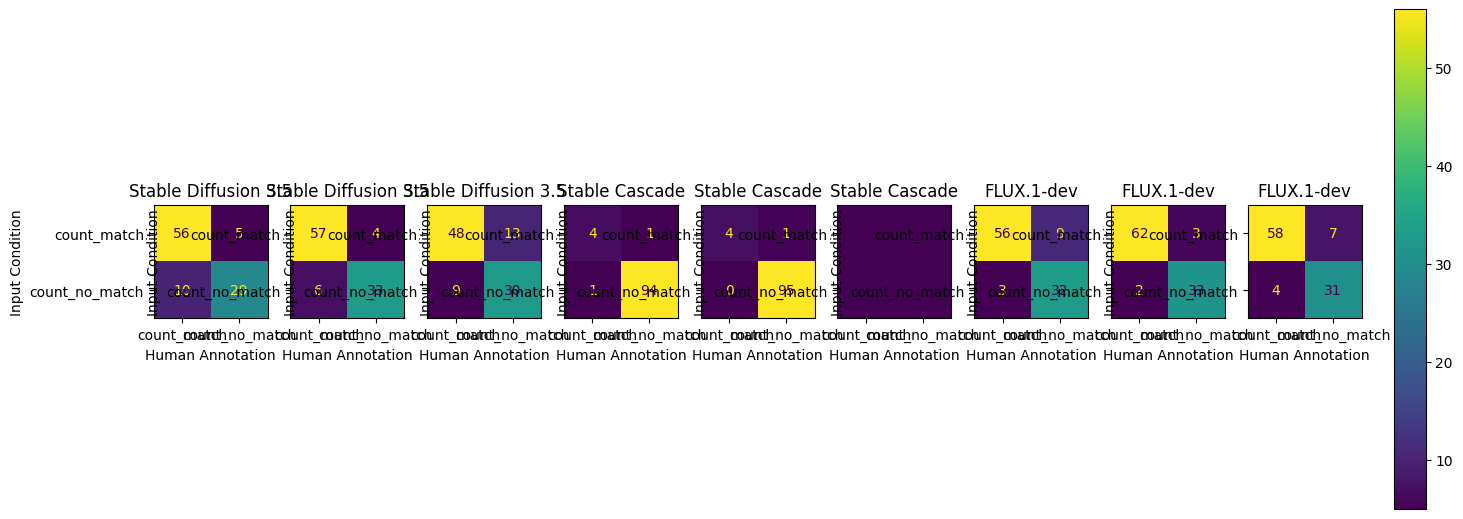

In [23]:
fig = plt.figure(figsize=(16, 5))

colorbar_image = None
i = 1
for id, path in IMAGE_MODEL.items():

    cfg = OmegaConf.load(f'{path}/config.yaml')

    for idx, cls in enumerate(cfg.classifier):
        df = pd.read_json(f'{path}/evaluate/dataset_{cls.id}.json', orient='records')

        m = df.loc[~df['oracle'].isna()]['metric']
        o = df.loc[~df['oracle'].isna()]['oracle']

        cm = confusion_matrix(o, m, labels=['count_match', 'count_no_match'])

    

    # cm = confusion_matrix(conditions, oracle, labels=['positive', 'neutral', 'negative'])
        ax = fig.add_subplot(1, 9, i)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['count_match', 'count_no_match'])
        cmd = display.plot(ax=ax, colorbar=False)

        cmd.ax_.set_title(f'{id}')
        cmd.ax_.set_xlabel(f'Human Annotation')
        cmd.ax_.set_ylabel(f'Input Condition')
        i += 1

        if colorbar_image is None:
            colorbar_image = cmd.im_
    
fig.subplots_adjust(right=0.88)  # Leave space on right for colorbar
cbar_ax = fig.add_axes([0.9, 0, 0.02, 1])  # [left, bottom, width, height]
fig.colorbar(colorbar_image, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Avoid overlapping with colorbar
plt.show()